In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab09.ipynb")

# Lab 9: Regression

Welcome to Lab 9!

Today we will get some hands-on practice with linear regression. You can find more information about this topic in
[Chapter 15.2](https://www.inferentialthinking.com/chapters/15/2/Regression_Line.html#the-regression-line).

**Submission**: Once you’re finished, run all cells besides the last one, select File > Save Notebook, and then execute the final cell. Then submit the downloaded zip file, that includes your notebook,  according to your instructor's directions.

In [2]:
# Run this cell, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)


# 1. How Faithful is Old Faithful? 

Old Faithful is a geyser in Yellowstone National Park that is famous for eruption on a fairly regular schedule. Run the cell below to see Old Faithful in action!

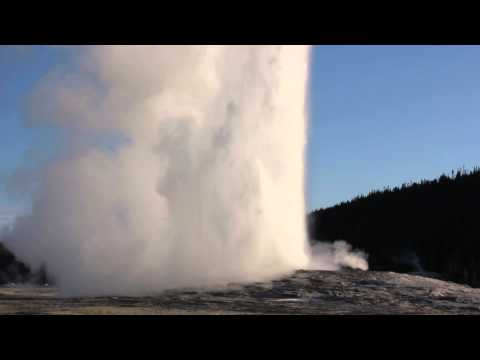

In [3]:
# For the curious: this is how to display a YouTube video in a
# Jupyter notebook.  The argument to YouTubeVideo is the part
# of the URL (called a "query parameter") that identifies the
# video.  For example, the full URL for this video is:
#   https://www.youtube.com/watch?v=wE8NDuzt8eg
from IPython.display import YouTubeVideo
YouTubeVideo("wE8NDuzt8eg")

Some of Old Faithful's eruptions last longer than others.  Whenever there is a long eruption, it is usually followed by an even longer wait before the next eruption. If you visit Yellowstone, you might want to predict when the next eruption will happen, so that you can see the rest of the park instead of waiting by the geyser.
 
Today, we will use a dataset on eruption durations and waiting times to see if we can make such predictions accurately with linear regression.

The dataset has one row for each observed eruption.  It includes the following columns:
- `duration`: Eruption duration, in minutes
- `wait`: Time between this eruption and the next, also in minutes

Run the next cell to load the dataset.

In [4]:
faithful = Table.read_table("faithful.csv")
faithful

duration,wait
3.6,79
1.8,54
3.333,74
2.283,62
4.533,85
2.883,55
4.7,88
3.6,85
1.95,51
4.35,85


**Question 1.0.** The following statements are the unordered steps of linear regression.  

1. Compute the parameters of the regression line: the slope and the intercept. 
2. Evaluate the regression line by computing the line’s RMSE and analyzing the residuals plot. 
3. Use the regression line to generate predictions for each x value. 
4. Determine if linear regression is a reasonable method by visualizing your data and computing the correlation coefficient. 

Make an array called `least_squares_order` that contains the correct order of a linear regression analysis, where the first item of the array is the first step of an linear regression analysis and the last item of the array is the last step of an linear regression analysis.


In [16]:
least_squares_order = make_array(4, 1, 3, 2)

In [17]:
grader.check("q1_0")

q1_0 results: All test cases passed!

We would like to use linear regression to make predictions, but that won't work well if the data aren't roughly linearly related.  To check that, we should look at the data.

**Question 1.1.** Make a scatter plot of the data.  It's conventional to put the column we want to predict on the vertical axis and the other column on the horizontal axis.


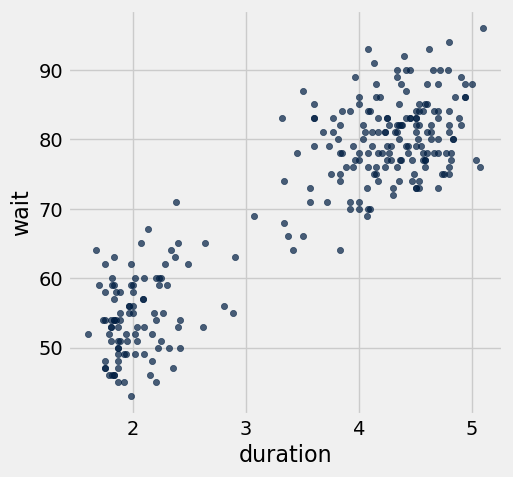

In [18]:
faithful.scatter("duration", "wait")

**Question 1.2.** Are eruption duration and waiting time roughly linearly related based on the scatter plot above? Is this relationship positive?


We're going to continue with the assumption that they are linearly related, so it's reasonable to use linear regression to analyze this data.

We'd next like to plot the data in standard units. If you don't remember the definition of standard units, textbook section [14.2](https://www.inferentialthinking.com/chapters/14/2/Variability.html#standard-units) might help!

**Question 1.3.** Compute the mean and standard deviation of the eruption durations and waiting times.  **Then** create a table called `faithful_standard` containing the eruption durations and waiting times in standard units.  The columns should be named `duration (standard units)` and `wait (standard units)`.


In [19]:
duration_mean = faithful.column("duration").mean()
duration_std = np.std(faithful.column("duration"))
wait_mean = faithful.column("wait").mean()
wait_std = np.std(faithful.column("wait"))

faithful_standard = Table().with_columns(
    "duration (standard units)", (faithful.column("duration") - duration_mean) / duration_std,
    "wait (standard units)", (faithful.column("wait") - wait_mean)/ wait_std)
faithful_standard

duration (standard units),wait (standard units)
0.0984989,0.597123
-1.48146,-1.24518
-0.135861,0.228663
-1.0575,-0.655644
0.917443,1.03928
-0.530851,-1.17149
1.06403,1.26035
0.0984989,1.03928
-1.3498,-1.46626
0.756814,1.03928


In [20]:
grader.check("q1_3")

q1_3 results: All test cases passed!

**Question 1.4.** Plot the data again, but this time in standard units.


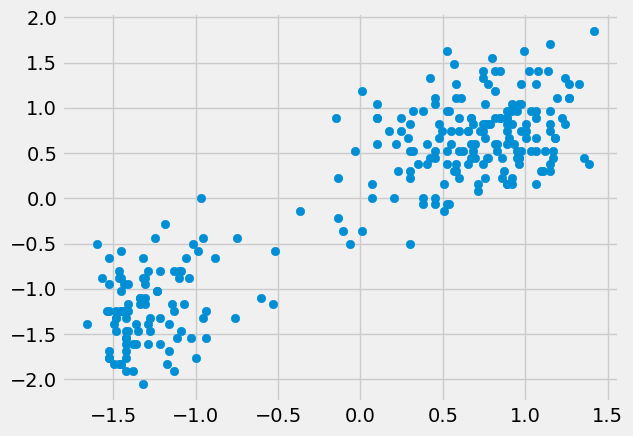

In [21]:
import matplotlib.pyplot as plt
plt.scatter(faithful_standard.column('duration (standard units)'), faithful_standard.column("wait (standard units)"))

You'll notice that this plot looks the same as the last one!  However, the data and axes are scaled differently.  So it's important to read the ticks on the axes.

**Question 1.5.** Among the following numbers, which would you guess is closest to the correlation between eruption duration and waiting time in this dataset?

1. -1
2. 0
3. 1

Assign `correlation` to the number corresponding to your guess (either 1, 2 or 3).


In [22]:
correlation = 3

In [23]:
grader.check("q1_5")

q1_5 results: All test cases passed!

**Question 1.6.** Compute the correlation coefficient: `r`.  

*Hint:* Use `faithful_standard`.  Section [15.1](https://www.inferentialthinking.com/chapters/15/1/Correlation.html#calculating-r) explains how to do this.



In [24]:
r = np.corrcoef(faithful_standard.column("duration (standard units)"), faithful_standard.column("wait (standard units)"))[0, 1]
r

0.90081116832181296

In [25]:
grader.check("q1_6")

q1_6 results: All test cases passed!

## 2. The regression line
Recall that the **correlation** is the **slope of the regression line when the data are put in standard units**.

The next cell plots the regression line in standard units:

$$\text{waiting time in standard units} = r \times \text{eruption duration in standard units}$$

Then, it plots the data in standard units again, for comparison.

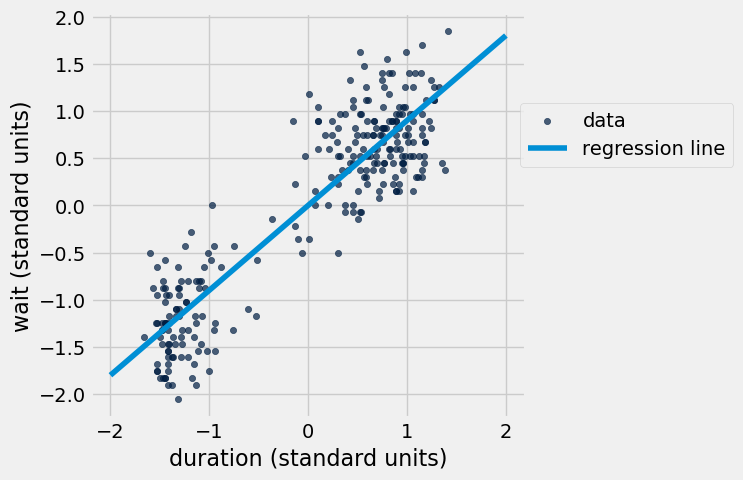

In [26]:
def plot_data_and_line(dataset, x, y, point_0, point_1):
    """Makes a scatter plot of the dataset, along with a line passing through two points."""
    dataset.scatter(x, y, label="data")
    xs, ys = zip(point_0, point_1)
    plots.plot(xs, ys, label="regression line")
    plots.legend(bbox_to_anchor=(1.5,.8))

plot_data_and_line(faithful_standard, 
                   "duration (standard units)", 
                   "wait (standard units)", 
                   [-2, -2*r], 
                   [2, 2*r])

How would you take a point in standard units and convert it back to original units?  We'd have to "stretch" its horizontal position by `duration_std` and its vertical position by `wait_std`. That means the same thing would happen to the slope of the line.

Stretching a line horizontally makes it less steep, so we divide the slope by the stretching factor.  Stretching a line vertically makes it more steep, so we multiply the slope by the stretching factor.

**Question 2.1.** Calculate the slope of the regression line in original units, and assign it to `slope`.

(If the "stretching" explanation is unintuitive, consult section [15.2](https://www.inferentialthinking.com/chapters/15/2/Regression_Line.html#the-equation-of-the-regression-line) in the textbook.)


In [27]:
slope = r * (np.std(faithful.column("wait")) / np.std(faithful.column("duration")))
slope

10.729641395133525

In [28]:
grader.check("q2_1")

q2_1 results: All test cases passed!

We know that the regression line passes through the point `(duration_mean, wait_mean)`. Recall that the equation of the regression line in the original units is:

$$\text{waiting time} = \text{slope} \times \text{eruption duration} + (- \text{slope} \times \text{duration\_mean + wait\_mean})$$


**Question 2.2.** Calculate the intercept in original units and assign it to `intercept`. [Section 15.2.5](https://inferentialthinking.com/chapters/15/2/Regression_Line.html#the-regression-line-in-standard-units) may be helpful.


In [29]:
intercept = -slope * duration_mean + wait_mean
intercept

33.474397022753358

In [30]:
grader.check("q2_2")

q2_2 results: All test cases passed!

## 3. Investigating the regression line
The slope and intercept tell you exactly what the regression line looks like.  To predict the waiting time for an eruption, multiply the eruption's duration by `slope` and then add `intercept`.

**Question 3.1.** Compute the predicted waiting time for an eruption that lasts 2 minutes, and for an eruption that lasts 5 minutes.


In [31]:
two_minute_predicted_waiting_time = slope * 2 + intercept
five_minute_predicted_waiting_time = slope * 5 + intercept

# Here is a helper function to print out your predictions.
# Don't modify the code below.
def print_prediction(duration, predicted_waiting_time):
    print("After an eruption lasting", duration,
          "minutes, we predict you'll wait", predicted_waiting_time,
          "minutes until the next eruption.")

print_prediction(2, two_minute_predicted_waiting_time)
print_prediction(5, five_minute_predicted_waiting_time)

After an eruption lasting 2 minutes, we predict you'll wait 54.933679813 minutes until the next eruption.
After an eruption lasting 5 minutes, we predict you'll wait 87.1226039984 minutes until the next eruption.


In [32]:
grader.check("q3_1")

q3_1 results: All test cases passed!

The next cell plots the line that goes between those two points, which is (a segment of) the regression line.

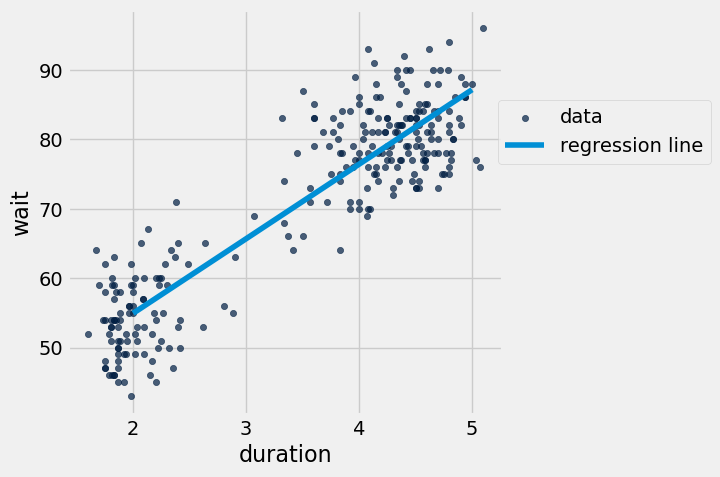

In [33]:
plot_data_and_line(faithful, "duration", "wait", 
                   [2, two_minute_predicted_waiting_time], 
                   [5, five_minute_predicted_waiting_time])

**Question 3.2.** Make predictions for the waiting time after each eruption in the `faithful` table.  (Of course, we know exactly what the waiting times were!  We are doing this so we can see how accurate our predictions are.)  Put these numbers into a column in a new table called `faithful_predictions`.  Its first row should look like this:

|duration|wait|predicted wait|
|-|-|-|
|3.6|79|72.1011|

*Hint:* Your answer can be just one line, though you are not limited to one line.  There is no need for a `for` loop; use array arithmetic instead.


In [34]:
predicted_waits = slope * faithful.column("duration") + intercept
faithful_predictions = faithful.with_column("predicted wait", predicted_waits)
faithful_predictions

duration,wait,predicted wait
3.6,79,72.1011
1.8,54,52.7878
3.333,74,69.2363
2.283,62,57.9702
4.533,85,82.1119
2.883,55,64.408
4.7,88,83.9037
3.6,85,72.1011
1.95,51,54.3972
4.35,85,80.1483


In [35]:
grader.check("q3_2")

q3_2 results: All test cases passed!

**Question 3.3.** How close were we?  Compute the *residual* for each eruption in the dataset.  The residual is the actual waiting time minus the predicted waiting time.  Add the residuals to `faithful_predictions` as a new column called `residual` and name the resulting table `faithful_residuals`.

*Hint:* Again, your code will be much simpler if you don't use a `for` loop.


In [36]:
residuals = faithful.column("wait") - faithful_predictions.column("predicted wait")
faithful_residuals = faithful_predictions.with_column("residual", residuals)
faithful_residuals

duration,wait,predicted wait,residual
3.6,79,72.1011,6.89889
1.8,54,52.7878,1.21225
3.333,74,69.2363,4.76371
2.283,62,57.9702,4.02983
4.533,85,82.1119,2.88814
2.883,55,64.408,-9.40795
4.7,88,83.9037,4.09629
3.6,85,72.1011,12.8989
1.95,51,54.3972,-3.3972
4.35,85,80.1483,4.85166


In [37]:
grader.check("q3_3")

q3_3 results: All test cases passed!

Here is a plot of the residuals you computed.  Each point corresponds to one eruption.  It shows how much our prediction over- or under-estimated the waiting time.

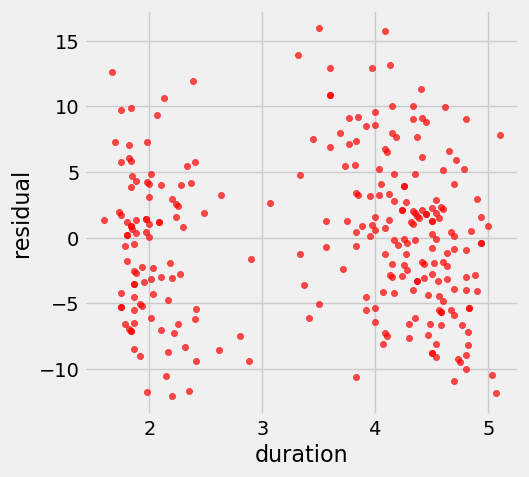

In [38]:
faithful_residuals.scatter("duration", "residual", color="r")

There isn't really a pattern in the residuals, which confirms that it was reasonable to try linear regression.  It's true that there are two separate clouds; the eruption durations seemed to fall into two distinct clusters.  But that's just a pattern in the eruption durations, not a pattern in the relationship between eruption durations and waiting times.

## 4. How accurate are different predictions?
Earlier, you should have found that the correlation is fairly close to 1, so the line fits fairly well on the training data.  That means the residuals are overall small (close to 0) in comparison to the waiting times.

We can see that visually by plotting the waiting times and residuals together:

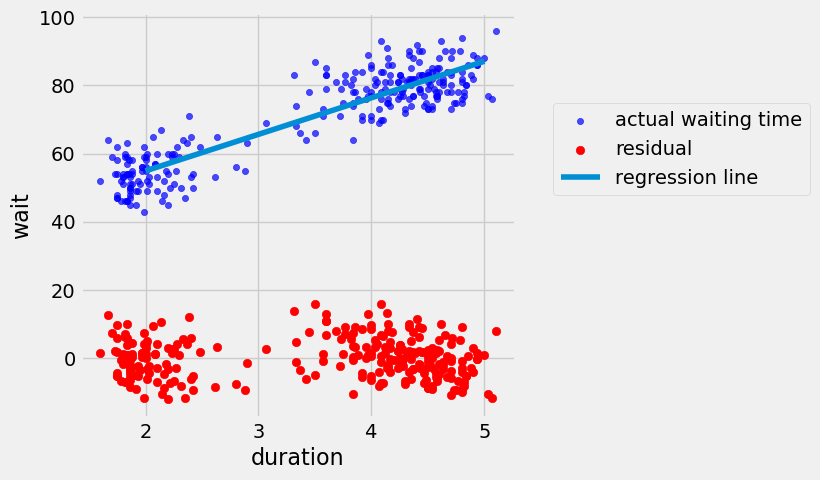

In [39]:
# Just run this cell.
faithful_residuals.scatter("duration", "wait", label="actual waiting time", color="blue")
plots.scatter(faithful_residuals.column("duration"), faithful_residuals.column("residual"), label="residual", color="r")
plots.plot([2, 5], [two_minute_predicted_waiting_time, five_minute_predicted_waiting_time], label="regression line")
plots.legend(bbox_to_anchor=(1.7,.8));

However, unless you have a strong reason to believe that the linear regression model is true, you should be wary of applying your prediction model to data that are very different from the training data.

**Question 4.1.** In `faithful`, no eruption lasted exactly 0, 2.5, or 60 minutes.  Using this line, what is the predicted waiting time for an eruption that lasts 0 minutes?  2.5 minutes?  An hour?


In [40]:
zero_minute_predicted_waiting_time = slope * 0 + intercept
two_point_five_minute_predicted_waiting_time = slope * 2.5 + intercept
hour_predicted_waiting_time = slope * 60 + intercept

print_prediction(0, zero_minute_predicted_waiting_time)
print_prediction(2.5, two_point_five_minute_predicted_waiting_time)
print_prediction(60, hour_predicted_waiting_time)

After an eruption lasting 0 minutes, we predict you'll wait 33.4743970228 minutes until the next eruption.
After an eruption lasting 2.5 minutes, we predict you'll wait 60.2985005106 minutes until the next eruption.
After an eruption lasting 60 minutes, we predict you'll wait 677.252880731 minutes until the next eruption.


In [41]:
grader.check("q4_1")

q4_1 results: All test cases passed!

**Question 4.2.** For each prediction, state whether you think it's reliable and explain your reasoning. 


## 5. Divide and Conquer

It appears from the scatter diagram that there are two clusters of points: one for durations around 2 and another for durations between 3.5 and 5. A vertical line at 3 divides the two clusters.

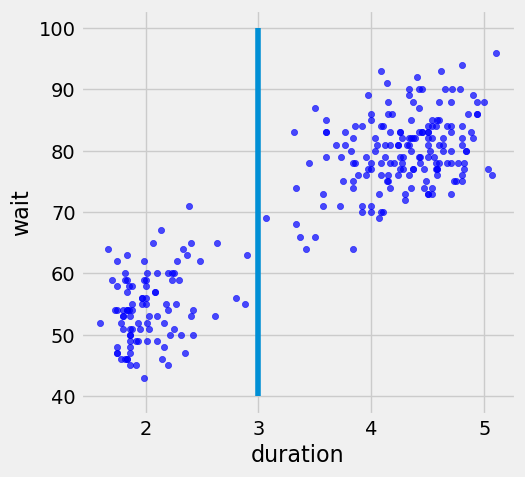

In [42]:
faithful.scatter("duration", "wait", label="actual waiting time", color="blue")
plots.plot([3, 3], [40, 100]);

The `standardize` function from lecture appears below, which takes in a table with numerical columns and returns the same table with each column converted into standard units.

In [43]:
# Just run this cell.

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)  

def standardize(t):
    """Return a table in which all columns of t are converted to standard units."""
    t_su = Table()
    for label in t.labels:
        t_su = t_su.with_column(label + ' (su)', standard_units(t.column(label)))
    return t_su

**Question 5.1.** Separately compute the correlation coefficient *r* for all the points with a duration below 3 **and then** for all the points with a duration above 3. To do so, create a function that computes `r` from a table, and then pass it two different tables of points, called `below_3` and `above_3`.

*Hint:* You can assume that the table does not have any duration values that are exactly 3. 


In [44]:
def corr_coeff(t):
    """Return the regression coefficient for columns 0 & 1."""
    t_su = standardize(t.select(0, 1))
    return np.mean(t_su.column(0) * t_su.column(1))

below_3 = faithful.where('duration', are.below(3))
above_3 = faithful.where('duration', are.above(3))
below_3_r = corr_coeff(below_3)
above_3_r = corr_coeff(above_3)
print("For points below 3, r is", below_3_r, "; for points above 3, r is", above_3_r)

For points below 3, r is 0.290189526493 ; for points above 3, r is 0.372782225571


In [45]:
grader.check("q5_1")

q5_1 results: All test cases passed!

**Question 5.2.** Complete the functions `slope_of` and `intercept_of` below. 

When you're done, the functions `wait_below_3` and `wait_above_3` should each use a different regression line to predict a wait time for a duration. The first function should use the regression line for all points with duration below 3. The second function should use the regression line for all points with duration above 3.


In [46]:
def slope_of(table, r):
    """Return the slope of the regression line for table in original units.
    
    Assume that column 0 contains x values and column 1 contains y values.
    r is the regression coefficient for x and y.
    """
    sx = np.std(table.column(0))
    sy = np.std(table.column(1))
    return r * sy / sx

def intercept_of(table, r):
    """Return the intercept of the regression line for table in original units."""
    slope = slope_of(table, r)  
    mean_x = np.mean(table.column(0))
    mean_y = np.mean(table.column(1))
    return mean_y - slope * mean_x
    
below_3_slope = slope_of(below_3, below_3_r)
below_3_intercept = intercept_of(below_3, below_3_r)
above_3_slope = slope_of(above_3, above_3_r)
above_3_intercept = intercept_of(above_3, above_3_r)

def wait_below_3(duration):
    return below_3_slope * duration + below_3_intercept

def wait_above_3(duration):
    return above_3_slope * duration + above_3_intercept

In [47]:
grader.check("q5_2")

q5_2 results: All test cases passed!

The plot below shows the two different regression lines, one for each cluster, along with the original regression line!

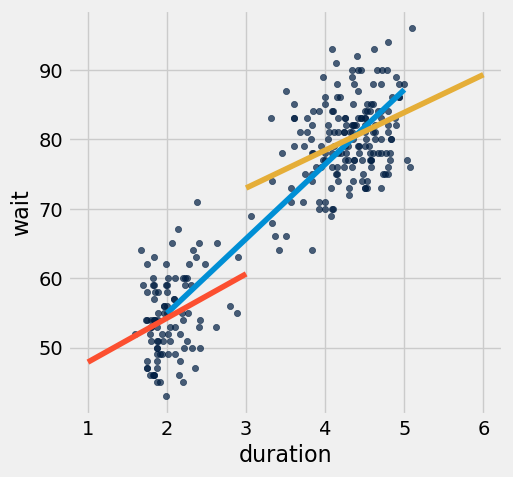

In [48]:
faithful.scatter(0, 1)
plots.plot([2, 5], [two_minute_predicted_waiting_time, five_minute_predicted_waiting_time])
plots.plot([1, 3], [wait_below_3(1), wait_below_3(3)])
plots.plot([3, 6], [wait_above_3(3), wait_above_3(6)]);

**Question 5.3.** Write a function `predict_wait` that takes a `duration` and returns the predicted wait time using the appropriate regression line, depending on whether the duration is below 3 or greater than (or equal to) 3.


In [ ]:
def predict_wait(duration):
    ...

In [ ]:
grader.check("q5_3")

The predicted wait times for each point appear below.

In [ ]:
faithful_pred_split = faithful.with_column('predicted', faithful.apply(predict_wait, 'duration'))
faithful_pred_split.scatter(0)

<!-- BEGIN QUESTION -->

**Question 5.4.** Do you think the predictions produced by `predict_wait` would be more or less accurate than the predictions from the regression line you created in section 2? How could you tell?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

The following cell will plot the residuals for each eruption in the dataset when we have one regression line and two regression lines. We also see the average magnitude of the residual values.

In [ ]:
# Just run this cell
faithful_pred_split_residuals = faithful_pred_split.with_column('residual', faithful_pred_split.column(1) - faithful_pred_split.column(2))
plots.scatter(faithful_residuals.column('duration'), faithful_residuals.column('residual'), label='one regression line')
plots.scatter(faithful_pred_split_residuals.column('duration'), faithful_pred_split_residuals.column('residual'), label='two regression lines');
plots.axis([1, 6, -15, 15])
plots.legend(bbox_to_anchor=(1.5,.8));
print("Average Magnitude of Residual Values for One Regression Line: ", np.mean(abs(faithful_residuals.column('residual'))))
print("Average Magnitude of Residual Values for Two Regression Lines: ", np.mean(abs(faithful_pred_split_residuals.column('residual'))))

The residual plot for the wait times when they are predicted by two regression lines (red) doesn't really have a pattern, which confirms that it was also appropriate to use linear regression in our "Divide and Conquer" scenario. How do the two residual plots compare?

## 6. Submission

<img src="lab09_pets.jpg" alt="drawing" width="500"/>

Congratulations, you're done with Lab 9!

**Important submission steps:** 
1. Run the tests and verify that they all pass.
2. Choose **Save Notebook** from the **File** menu, then **run the final cell**. 
3. Click the link to download the zip file.
4. Then submit the zip file to the corresponding assignment according to your instructor's directions. 

**It is your responsibility to make sure your work is saved before running the last cell.**

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)